For our final project, we have chosen to analyze Spotify music data, focusing on key attributes of songs. This dataset comprises various features, including track duration, explicit content, danceability, energy, and more.

Our central question revolves around predicting the danceability of a song based on its musical characteristics and qualities. Specifically, we aim to investigate the following:

Can we predict the danceability of a song based on musical characteristics/qualities? What qualities of a song contribute the most to its danceability?

The motivation and value behind this question is to provide valuable insights for clubs and DJs, offering a greater understanding of the factors that influence a song's danceability. By determining which musical attributes contribute significantly to a song's danceability, stakeholders can make informed decisions to enhance the appeal and marketability of their music. 

Our question is relevant to the music industry, where the abitity to predict a song's danceability directly impacts revenue generation.


We found our dataset on this website: https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/tree/main 

Our data set is 6 months old, 20.1 MB, containing 20 columns, and 114001 rows. This is a recent dataset with a large enough size to give us accurate and unbiased data.

The columns that we are working with to analyze are as follows: track_id, artists, album_name, track_name, popularity, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre

When we first began our project, our primary goal was to assess song popularity based on musical characteristics and quality. However, as we began to construct a model, we encountered challenges with accuracy in predicting a song's popularity from the available data. This discrepancy was due to a high amount of zeros in the popularity data, skewing our results. Additionally, we realized that popularity is a subjective quality influenced by various factors, including seasonal considerations (e.g., Christmas songs), extending beyond mere musical features.

We shifted our focus to identifying a more robust target variable for prediction. We found that danceability proved to be a superior target variable. Not only does it have a more direct correlation with the musical features in our X variable, but it also provides a more nuanced and reliable indicator of a song's appeal.

In [370]:
# step 1: import the libraries and upload the dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
from fairlearn.metrics import MetricFrame
import warnings
warnings.filterwarnings("ignore")


# open the dataset.csv file 
music = pd.read_csv('dataset.csv')
# inspect the types of each column
music.dtypes


Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [282]:
music.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


We decided that the best model to use for our question would be Random forest. This is because we have alot of key features that are both numerical and categorical. 

We want to use random forest to be able to determine what factors contribute the most to danceability. RF is an adequate model for our question because they work with both numerical and categorical data, flexible, and easy to interpret.



First, lets clean our data set a little bit for manipulation. 

In [283]:
# check how many nas 
music.isna().sum()
# not too many nas, so we can drop them 
music = music.dropna()


We plotted the correlation matrix for the data. 
We can see initially that the columns that correlate the most with danceability are: Loudness, Valence, and Time 
The columns that seem to correlate the least with danceability are: Instrumentalness and Acousticness. This could be due to danceability only being high for more techno pop music and less instrumental songs. 

<AxesSubplot:>

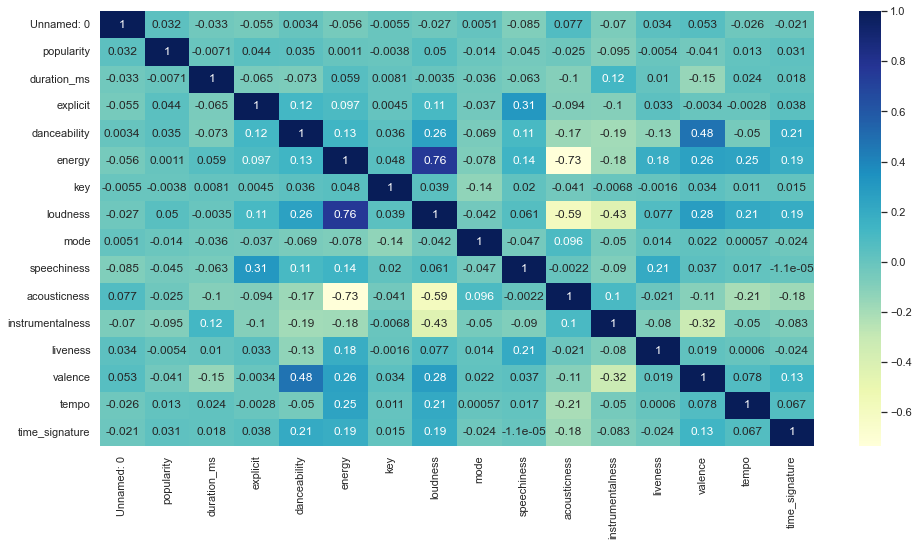

In [284]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr =music.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")


Lets do some more exploratory data analysis on the data

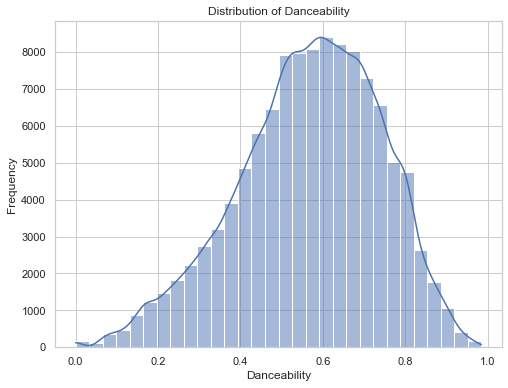

In [285]:

import seaborn as sns
# Distribution of the target variable (danceability)
plt.figure(figsize=(8, 6))
sns.histplot(music["danceability"], bins=30, kde=True)
plt.title("Distribution of Danceability")
plt.xlabel("Danceability")
plt.ylabel("Frequency")
plt.show()


Lets visualize the distribution of numerical features

                                 Numeric Features Distribution                                  


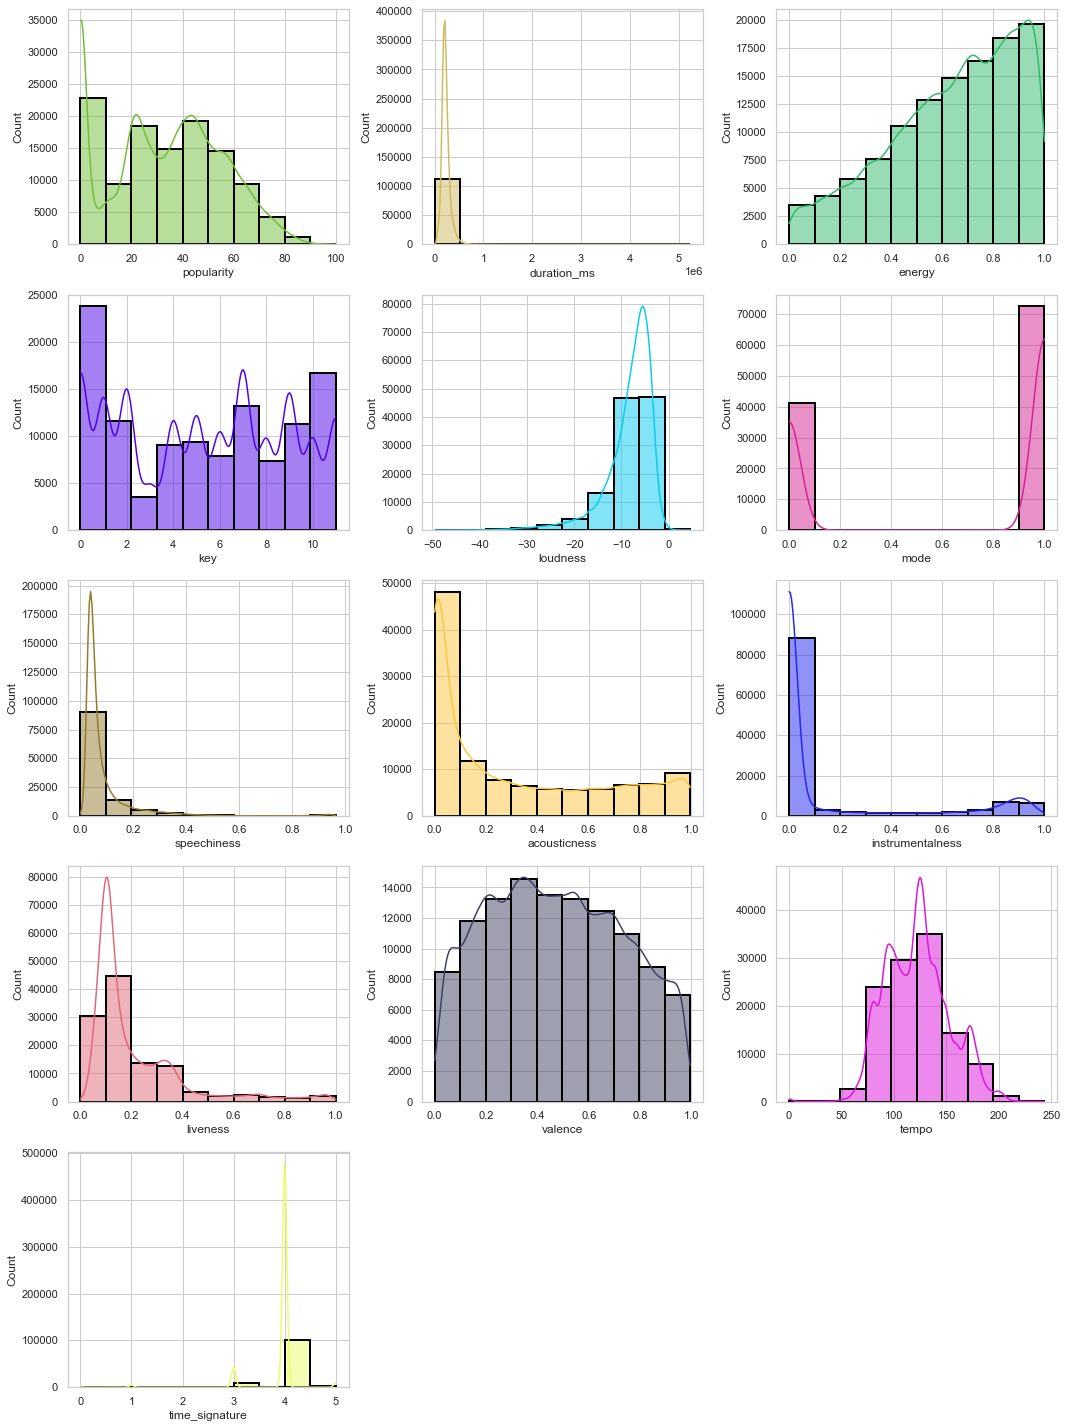

In [372]:
import math


target_column = 'danceability'
numerical_features = music.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop(target_column)
# drop unnamed column
numerical_features = numerical_features.drop('Unnamed: 0')


print('\033[1mNumeric Features Distribution'.center(100))

# Define number of subplots per row
subplots_per_row = 3
num_rows = math.ceil(len(numerical_features) / subplots_per_row)

plt.figure(figsize=[15, 4 * num_rows])

for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, subplots_per_row, i + 1)
    sns.histplot(
        music[feature],
        kde=True,  # Add a kernel density estimate
        color=list(np.random.randint([255, 255, 255]) / 255),
        edgecolor="black", 
        linewidth=2,
        bins=10
    )

plt.tight_layout()
plt.show()


We can see from the danceability distribution that most of the data has a danceability around .6/.7. this means that most of the data has an average danceability score. This is good because we don't want the distribution to be skewed too much in one direction. When we first tried to determine popularity, the distribution showed a max at 0.0, which led to errors and bias later on. 

In [286]:
# lets fix some of the columns values --> example some of the track names are not legible
# lets remove the ones that are not in english, with any letters that contain special symbols 
# in another language other than english 
music = music[music['track_name'].str.contains('^[a-zA-Z ]+$')]
music['track_name'].value_counts()
# lets drop track_id because it is just a bunch of letters 
music = music.drop(['track_id'], axis = 1)
# also remove the unnamed column
music = music.drop(['Unnamed: 0'], axis = 1)
# lets also drop album name because this wont really contribute to danceability 
music = music.drop(['album_name'], axis = 1)
# lets also drop artists since we dont have any tell about the artists fame 
music = music.drop(['artists'], axis = 1)
# lets also drop explicit because this won't really contribute to danceability
music = music.drop(['explicit'], axis = 1)
# lets also drop the track name because this wont really contribute to danceability
music = music.drop(['track_name'], axis = 1)
# we want to be able to predict danceability of the track, so maybe we can add this in later 



In [287]:
music.head()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
2,57,210826,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
4,82,198853,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,58,214240,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,74,229400,0.407,0.147,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic


In [288]:
# lets normalize the numerical data, as a min max scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# select all the numerical columns and min max scale them 
music[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']] = scaler.fit_transform(music[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']])
music.head()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,0.048552,0.686294,0.460989,0.090909,0.779395,0.0,0.148187,0.032329,0.000001,0.354151,0.718593,0.361245,0.8,acoustic
2,57,0.043952,0.444670,0.358987,0.000000,0.720948,1.0,0.057720,0.210843,0.000000,0.109419,0.120603,0.313643,0.8,acoustic
4,82,0.041176,0.627411,0.442989,0.181818,0.721984,1.0,0.054508,0.470884,0.000000,0.074791,0.167839,0.492863,0.8,acoustic
5,58,0.044743,0.698477,0.480990,0.545455,0.739080,1.0,0.108808,0.290161,0.000000,0.182534,0.669347,0.402746,0.8,acoustic
6,74,0.048258,0.413198,0.146983,0.181818,0.738787,1.0,0.036788,0.860442,0.000003,0.083321,0.076884,0.580527,0.6,acoustic


Initially we included track_genre in our features, even though it was the only categorical variable (we one hot encoded it). However, due to the excess number of columns crowding our final plots, we decided to drop it since it was the least important feature for Danceability, and additionally none of our results changed once it was dropped. 

In [289]:
# drop track_genre 
music = music.drop(['track_genre'], axis = 1)


In [290]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = music['danceability']
X = music.drop(['danceability'], axis = 1)


In [291]:
# right now danceability is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not danceable or danceable 
# the cutoff is 0-0.6 and then 0.6-1.0

# lets create a function that will change the danceability to either 0 or 1
def danceability_change(danceability):
    if danceability < 0.60:
        return 0
    else:
        return 1

# lets apply this function to our y variable
y = y.apply(danceability_change)


In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
#start with 10% of our dataset, could do 20% but random forest does require more training data
#because of the sampling so 90% might be a better approach with this small of a dataset
#remember, use random_state to create reproducible results


In [293]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())


0    24462
1    23562
Name: danceability, dtype: int64
0    10484
1    10099
Name: danceability, dtype: int64


We can see that the value counts for not danceable (0) and danceable (1) are relatively even. This will be good for our results

In [294]:

random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }


In [321]:

print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 --> originally was at 11 but after removing track_genre, it decreased due to less columns

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

song_RF= RFC.fit(X_train,y_train)

# finished in 22 seconds



max_features = 3.605551275463989


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


In [322]:
print('OOB error rate: ' + str(1-song_RF.oob_score_))
# 25% error rate, not bad


OOB error rate: 0.25116608362485426


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


False Positive Rate: 0.2400
True Positive Rate: 0.7383


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


0.7493544894219557

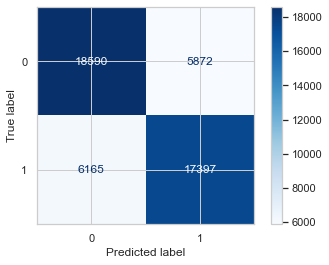

In [323]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = song_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=song_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")

song_RF.score(X_train,y_train) 



We can see from the confusion matrix that we have a pretty good estimate from our model. There are definitely more correct predictions than incorrect and we can see that the False positive rate is 24% and the True positive rate is 74%. 
Accuracy is 75%

In [324]:
#calcuating recall and precision
#recall = TP/(TP+FN)
#precision = TP/(TP+FP)

recall = 13613/(13613+8955)
print(recall)
#not bad because .60 is closish to 1

precision = 13613/(13613+3735)
print(precision)
#not bad because .78 is close to 1


0.603199220134704
0.7847014065021904


Recall is the ratio of correctly predicted positive observations to the total actual positives. Precision is the ratio of correctly predicted positive observations to the total predicted positives. A recall of 60.29% indicates that the model is capturing a significant portion of the actual positive instances.A precision of 78.45% indicates that when the model predicts positive, it is correct about 78.45% of the time.

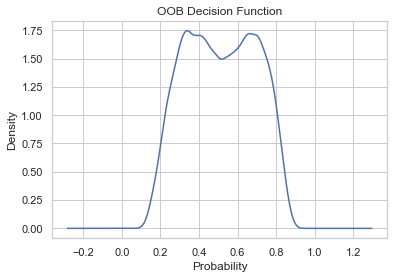

In [325]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.60
xx = pd.DataFrame(song_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()


In [326]:
#determining feature importance

np.argmax(song_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(song_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))


                  importance
valence             0.232667
acousticness        0.127708
tempo               0.113221
energy              0.105993
speechiness         0.077779
liveness            0.067031
duration_ms         0.066396
loudness            0.064675
popularity          0.048173
instrumentalness    0.047866
key                 0.030890
mode                0.009107
time_signature      0.008492


We can see tha Valence is the most important (at 23%), and following are tempo, acousticness, energy, speechiness

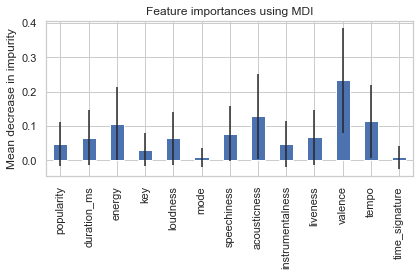

In [327]:
#Here we compute both the mean and standard
# deviation of accumulation of the impurity decrease within each tree.
importances = song_RF.feature_importances_

std = np.std([tree.feature_importances_ for tree in song_RF.estimators_], axis=0)

#graph it
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [328]:
 #Permutation feature importance does not have a bias toward 
 # high-cardinality features and can be computed on a test set. 
 # This will allow us to view the mean decrease in accuracy of each feature...
result = permutation_importance(
    song_RF, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2, scoring='precision'
)

# Combine results and column names to visualize
forest_importances = pd.Series(result.importances_mean, index=X.columns)


# after removing the track_genre it runs much faster 


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=

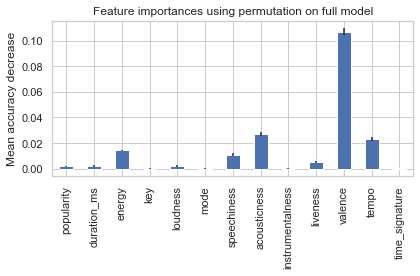

In [329]:
#The same features are detected as most important using both methods. 
# Although the relative importances vary
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# mean accuracy decrease in valence is the largest 



MDI quantifies the importance of each feature by measuring how much each feature contributes to impurity reduction during tree building. 

Permutation feature importance measures the importance of individual features in the model without a bias towards high-cardinality features.

The same features are detected as most important using both methods. 

We observe that the mean accuracy decrease for the "valence" feature is much higher than for other features in your permutation feature importance analysis. This indicates that the model heavily relies on the "valence" feature for making accurate predictions. A higher mean accuracy decrease for a feature implies that permuting the values of that feature has a more significant impact on the model's performance. However, the high importance of "valence" is expected based on our domain knowledge of danceability. Valence is genuinely a crucial factor in the problem, so this means that the model is capturing an important pattern. 

In [330]:
# now lets look at the difference in results when we change the number of trees
n_estimators_list = [100,200,300,400,500,600,700,800,900,1000]
forest_list = [RandomForestClassifier( n_estimators = n,
            max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p)
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                    warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in n_estimators_list]

forest_list[:3]


[RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        oob_score=True, random_state=1984, warm_start=True),
 RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True)]

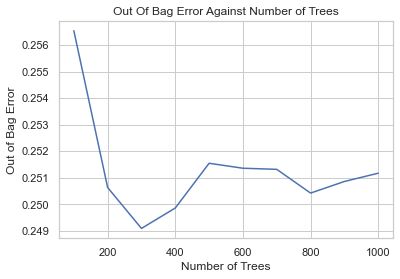

In [331]:
# Let's visualize the results of the random forest.
# Let's start by looking at how the error rate changes as we add more trees.

oob_errors = ([1-i.oob_score_ for i in forest_list])
plt.plot(n_estimators_list,oob_errors)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.show()

# there are some rises and falls in our OOB error rate, but notice that the y axis varies by  very small decimal numbers
# the rate is generally decreasing as we add more trees 
# lowest at 300



In [332]:
# We want to do the best we can to label a song as danceable 
# later we can certainly adjust the threshold but want to tune to optimize the models ability 
# to identify the positive target class. 

pd.DataFrame(list(zip(n_estimators_list,oob_errors)), columns = ['number of trees','oob_error'])

# lowest 00B is at 300-400


,number of trees,oob_error
0,100,0.256538
1,200,0.250625
2,300,0.249084
3,400,0.249854
4,500,0.251541
5,600,0.251353
6,700,0.251312
7,800,0.250416
8,900,0.250854
9,1000,0.251166


In [333]:
# Let's grab our random forest model we made with 600ish trees.


song_RF_eng = forest_list[2]
song_RF_eng #good




RandomForestClassifier(max_features=4, max_samples=100, min_samples_leaf=5,
                       n_estimators=300, oob_score=True, random_state=1984,
                       warm_start=True)

original model error: 0.25116608362485426


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.3s finished


new model error: 0.2490837914376145


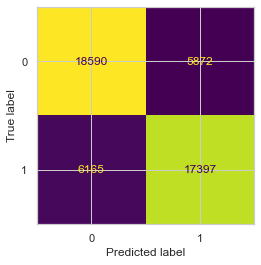

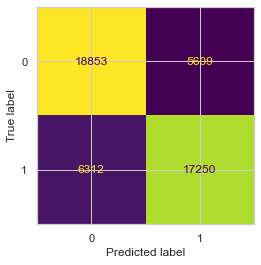

In [334]:
# Let's compare the confusion matrices between our 2 random forest models and the associated total error rates.
#original
print('original model error: ' +str(1-song_RF.oob_score_))
ConfusionMatrixDisplay.from_estimator(song_RF,X_train,y_train, colorbar= False)

#New
print('new model error: ' + str(1-song_RF_eng.oob_score_))
ConfusionMatrixDisplay.from_estimator(song_RF_eng,X_train,y_train, colorbar= False)


# not too much difference but it gets slightly better
# everything improves besides true positive rate 


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


0.7543603945003158

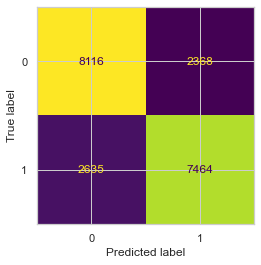

In [335]:
#Use the .predict function on our testing data with new model

song_predict = song_RF_eng.predict(X_test)

#create confusion matrix of test data predictions
ConfusionMatrixDisplay.from_predictions(y_test,song_predict, colorbar= False)

song_RF.score(X_test,y_test) 


Accuracy improved by a few decimal points

In [355]:
# now lets look at the difference in results when we change the number of features
max_features_list = [6,7,8,9,10,11,12,13,14,15]

forest_list2 = [RandomForestClassifier(n_estimators = 300,
            max_features= n, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.  # testing from 300-->100
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                    warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in max_features_list]
forest_list2[:3]


[RandomForestClassifier(max_features=6, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=7, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=8, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True)]

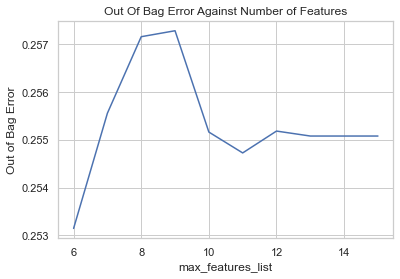

In [356]:
oob_errors1 = ([1-i.oob_score_ for i in forest_list2])
plt.plot(max_features_list,oob_errors1)
plt.title('Out Of Bag Error Against Number of Features')
plt.xlabel('max_features_list')
plt.ylabel('Out of Bag Error')
plt.show() 

# lowest number of features is at 6


A decreasing OOB error rate with fewer features and an increase with more features suggests a potential overfitting issue or a point of diminishing returns in terms of feature inclusion. 
We dont want to overfit, so lets stick with a lower number of features

In [357]:
#assign correct model
song_RF_tune = forest_list2[0]
# 6 features --> lowest 
song_RF_tune #good


RandomForestClassifier(max_features=6, max_samples=100, min_samples_leaf=5,
                       n_estimators=300, oob_score=True, random_state=1984,
                       warm_start=True)

Text(0.5, 0, 'False Positive Rate')

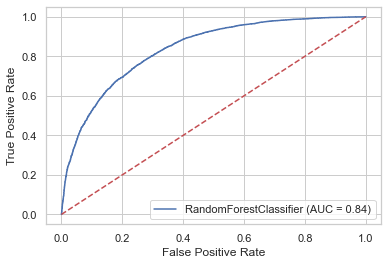

In [358]:
# Let's see how our relative true positives compare to the false positives.
# To do that we'll need to plot a ROC curve.

#Quickest and easiest method is to simply use the sklearn function RocCurveDisplay with our model and testing features + target
#This will give us an ROC plot with all reasonable thresholds given the probabilities of prediction
metrics.RocCurveDisplay.from_estimator(song_RF_tune, X_test,y_test)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


In [359]:
#We can see where our optimal threshold is (closest point to top left corner), but let's get the exact value of it now 
#First get prediction probabilities of test data, only want positive class so extract second column
pred = song_RF_tune.predict_proba(X_test)[:,1]
#Use roc_curve function to get fpr, tpr and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
pd.DataFrame(list(zip(thresholds, tpr, fpr)),columns = ['thresholds','tpr','fpr']).head(27) #good
# at lower thresholds our true positive and false positive rates increase


,thresholds,tpr,fpr
0,inf,0.000000,0.000000
1,0.932392,0.000099,0.000000
2,0.916726,0.000198,0.000000
3,0.909888,0.000495,0.000000
4,0.902003,0.001485,0.000000
5,0.901968,0.001485,0.000095
6,0.898726,0.002079,0.000095
7,0.897698,0.002079,0.000191
8,0.896134,0.002376,0.000191
9,0.895152,0.002475,0.000191


In [360]:
#Locate index of best threshold, this is where true postive rate is highest and false positive rate is the lowest
ix = np.argmax(tpr-fpr) #np.argmax returns the index of maximum values along and axis
print('Best threshold: ' + str(thresholds[26]))

# best threshold is .88 --> this is different than the original distribution model which showed .60 


Best threshold: 0.8844100529100536


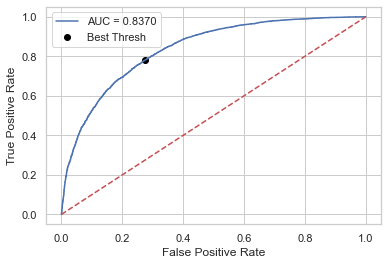

In [361]:
# plot the roc curve for the model with best threshold highlighted
#Get auc score first to add to plot
auc = metrics.roc_auc_score(y_test, pred)
#plot fpr and tpr
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % auc) 
#add in best threshold highlight
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Thresh')
# axis labels
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()


Fairness eval: Since our data doesn't include demographic factors such as gender, race, or age, and it primarily focuses on numerical features of musical quality, the potential for bias is reduced. We ensured that preprocessing steps did not introduce bias, and the dataset provided sufficient information to avoid misleading or mislabeled data.

The ROC curve above demonstrates the model's performance, with an AUC value of .83. The optimal threshold for equality of odds and equal opportunity is determined by the point on the curve where True Positive Rate (sensitivity) equals False Positive Rate. The red dot on the ROC curve indicates the best threshold, which is .83. An AUC of 0.83 is generally considered to be a good performance, indicating that the model has a relatively high ability to discriminate between positive and negative cases.

In [374]:
from lime.lime_tabular import LimeTabularExplainer

# Danceability observation

explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),  # Convert feature names to a list
    class_names=['<.8 Danceability', '>= .8 Danceability'],
    discretize_continuous=True
)

# Choose an observation to explain
observation = 85

# Get the explanation for RF
exp = explainer.explain_instance(
    X_train.values[observation],
    song_RF_eng.predict_proba,
    num_features=15
)

# Save the explanation to an HTML file
exp.save_to_file('lime_explanation.html')

##Observation 85 has prediction probability that it will be >= .8 danceability, 73% chance of predicting correctly 


In conclusion, we found that we can pretty accurately predict song danceability with musical features. 

An AUC of 0.83 indicates the model has strong discriminatory ability to distinguish between a <0.8 danceability and >=0.8 danceability 

Songs with high valence (happiness) >0.68, high speechiness >0.09 significantly contribute to increased danceability of a song

Songs in the track genre mandopop (Mandarin pop music) are more likely to be considered danceable by the model 

As DJs and clubs consider curating playlists they should be aware of the valence and speechiness of a song, and should consider playing Mandarin pop music. 

Our data set did have limitations, in dropping special symbols and characters, we dropped some non English international tracks that could have changed the results of our model. 

We also measured danceability using 15 features, more features such as rhythym stability, less subjective than popularity and more related to danceability than track duration could have had a more significant impact on our results. 

In future work the model could be altered to determine danceability of tracks from different countries, so DJs from different countries can cater to their specific audiences. 